In [1]:
using GraphPPL, Rocket, ReactiveMP
using Random, Distributions, LinearAlgebra, Revise
using Plots

## Solving GP Regression by SDE
In this notebook, we use kernel Matern-5/2. Recall the definition of Matern kernel:
$$
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
$$

and the state-space model:
$$
\mathbf{f}_k = \mathbf{A}_{k-1} \, \mathbf{f}_{k-1} + \mathbf{q}_{k-1}, \quad \mathbf{q}_{k-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_{k-1}) 
$$
$$
y_k = \mathbf{H} \, \mathbf{f}(t_k) + \epsilon_k , \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{noise}).
$$
The matrices for the SDE representation of the Matern-52 are:
$$
\mathbf{F} = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1 \\
-\lambda^3 & -3\lambda^2 & -3\lambda
\end{pmatrix} ,\quad \quad \mathbf{L} = \begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}, \quad \quad \mathbf{H} = \begin{pmatrix}
1 & 0 & 0
\end{pmatrix}, \quad \quad Q_c = \frac{16}{3} \sigma^2 \lambda^5, 
$$
where $\lambda = \sqrt{5} / l$. To find $\mathbf{P}_\infty$, we solve the Lyapunov equation
$$
\frac{d\mathbf{P}_\infty}{dt} = \mathbf{F} \mathbf{P}_\infty + \mathbf{P}_\infty \mathbf{F}^T + \mathbf{L} \mathbf{Q}_c \mathbf{L}^T = 0,
$$
and the solution of the equation is
$$ 
vec(\mathbf{P}_\infty) = (\mathbf{I} \otimes \mathbf{F} + \mathbf{F}\otimes\mathbf{I})^{-1}\, vec(-\mathbf{L}Q_c\mathbf{L}^T)
$$   
where $vec(.)$ is the vectorization operator and $\otimes$ denotes the Kronecker product. Now we can find $\mathbf{A}_k$ and $\mathbf{Q}_k$ 
$$
\mathbf{A}_k = \exp{(\mathbf{F}\Delta t_k)} 
$$
$$
\mathbf{Q}_k = \mathbf{P}_\infty - \mathbf{A}_k \mathbf{P}_\infty \mathbf{A}_k^T  
$$

## Specify model

In [2]:
@model function gp_regression(n, P∞, A, Q, H)
    f_0 ~ MvNormalMeanCovariance(zeros(3), P∞)
    f = randomvar(n)
    y = datavar(Float64, n) where { allow_missing = true }
    
    f_prev = f_0

    for i=1:n
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        y[i] ~ NormalMeanVariance(dot(H , f[i]), 0.04)
        f_prev = f[i]
    end
    return f, y
end

In [3]:

@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::Missing, q_Σ::PointMass, ) = missing

@rule typeof(*)(:in, Marginalisation) (m_out::Missing, m_A::PointMass, meta::TinyCorrection) = missing

@rule NormalMeanVariance(:μ, Marginalisation) (q_out::Missing, q_v::PointMass) = missing

@rule typeof(dot)(:in2, Marginalisation) (m_out::Missing, m_in1::PointMass, meta::TinyCorrection) = missing

## Generate data

In [4]:
Random.seed!(10)
n = 100

t = collect(range(0, 5, length=n)); #timeline
f_true = 2*sin.(t) .+ cos.(2*t); # true process
f_noisy = f_true + sqrt(0.04)*randn(n); #noisy process

pos = sort(randperm(75)[1:2:75]); 
t_obser = t[pos]; # time where we observe data

y_data = Array{Union{Float64,Missing}}(missing, n)
for i in pos 
    y_data[i] = f_noisy[i]
end

θ = [1., 1.]; # store [l, σ²]
λ = sqrt(5)/θ[1];
Δt = [t[1]]; #time difference
append!(Δt, t[2:end] - t[1:end-1]);

#### compute matrices for the state-space model ######
L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

I = diageye(3) ; 
vec_P = inv(kron(I,F) + kron(F,I)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [5]:
result = inference(
    model = Model(gp_regression, n, P∞, A, Q, H),
    data = (y = y_data,)
)

Inference results:
-----------------------------------------
f   = Vector{AbstractMvNormal}[[MvNormalWeightedMeanPrecision(
xi: [65.85526392511194,...
f_0 = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...


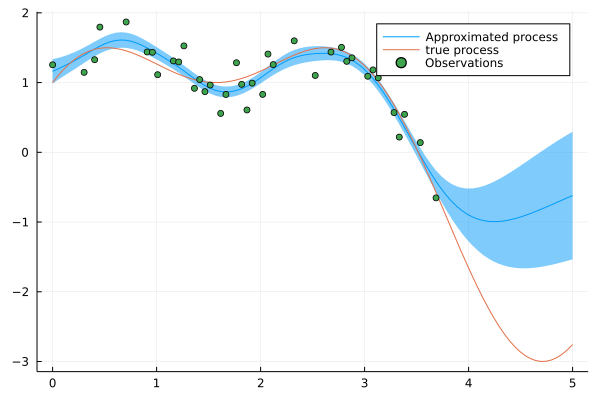

In [6]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

px = plot()
px = plot!(px, t, mean.(result.posteriors[:f][]) |> slicedim(1), ribbon = var.(result.posteriors[:f][]) |> slicedim(1) .|> sqrt, label ="Approximated process")
px = plot!(px, t, f_true,label="true process")
px = scatter!(px, t_obser, f_noisy[pos], label="Observations")
